## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [10]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [11]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 
finalTestDF = getDataframe(dataDict['finalTest']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 2567


In [12]:
trainDF.head()

,files,labels,category
0,speechData/train/four/815f0f03_nohash_0.wav,3,four
1,speechData/train/cat/8c7c9168_nohash_1.wav,12,cat
2,speechData/train/stop/8a1c449e_nohash_0.wav,0,stop
3,speechData/train/six/bd2db1a5_nohash_1.wav,23,six
4,speechData/train/four/fbf3dd31_nohash_0.wav,3,four


## Install tf 2.0

In [7]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 51.9MB/s 


In [8]:
import tensorflow as tf

print("Version: ", tf.__version__)

Version:  2.0.0-beta1


## Load pretrained model

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from models import cnnModel

GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/cnnModel/"

model = cnnModel()
model.load_weights(GDRIVE_PATH+'model_weights.h5')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 40, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 40, 16)        6

## Extract features

In [0]:
from trainingUtils import getDataset

marvin_data, _ = getDataset(
    df=trainDF.loc[trainDF['category']=='marvin', :],
    batch_size=32,
    cache_file='oc_train_cache',
    shuffle=False
)

In [0]:
def getFeatures(data):
    layer_name = 'dense_1'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)

In [0]:
X_train = getFeatures(marvin_data)

In [0]:
from sklearn 

In [31]:
from sklearn import svm

oc_svm = svm.OneClassSVM()
ocmodel = oc_svm.fit(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
valDF['oc_class'] = valDF.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
val_true = valDF['oc_class'].tolist()
valDF.head()

,files,labels,category,oc_class
0,speechData/train/bed/026290a7_nohash_0.wav,16,bed,-1
1,speechData/train/bed/060cd039_nohash_0.wav,16,bed,-1
2,speechData/train/bed/060cd039_nohash_1.wav,16,bed,-1
3,speechData/train/bed/099d52ad_nohash_0.wav,16,bed,-1
4,speechData/train/bed/0e17f595_nohash_0.wav,16,bed,-1


In [0]:
!pip install -q python_speech_features

In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank

def _parse_fn(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return fbank

In [0]:
import numpy as np
valData = np.zeros((valDF.shape[0], 99, 40))

for i,f in enumerate(valDF['files']):
    valData[i] = _parse_fn(f)

In [0]:
X_val = getFeatures(valData)

In [0]:
val_pred = oc_svm.predict(X_val)

In [0]:
def showResults(y_pred, y_true):
    
    from sklearn.metrics import (
        accuracy_score, recall_score,
        precision_score, f1_score,
        confusion_matrix
    )
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt


    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {:.4f}".format(precision_score(y_true, y_pred)))
    print("Recal: {:.4f}".format(recall_score(y_true, y_pred)))
    print("F1-score: {:.4f}".format(f1_score(y_true, y_pred)))

    cm = confusion_matrix(y_pred, y_true).T
    df_cm = pd.DataFrame(cm, ['Other', 'Marvin'],['Other', 'Marvin'])

    fig = plt.figure(figsize=(6,6))
    _ = sns.heatmap(df_cm,cmap='Blues', fmt='g', annot=True,annot_kws={"size": 16}, cbar=False)
    plt.title('Confusion matrix', fontsize=20)
    plt.ylabel('True class', fontsize=15)
    plt.xlabel('Predicted class', fontsize=15)

    plt.tight_layout()
    plt.show()

Accuracy: 0.9873
Precision: 1.0000
Recal: 0.4625
F1-score: 0.6325


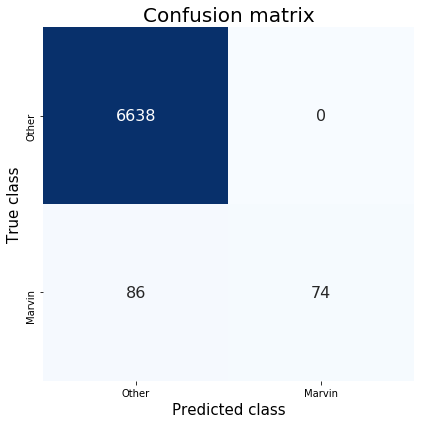

In [44]:
showResults(val_pred, val_true)

In [45]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest() #random_state=42, contamination=0.1, bootstrap='True', max_samples=50, behaviour='new'
isf.fit(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [47]:
val_pred = isf.predict(X_val)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Accuracy: 0.9975
Precision: 1.0000
Recal: 0.8938
F1-score: 0.9439


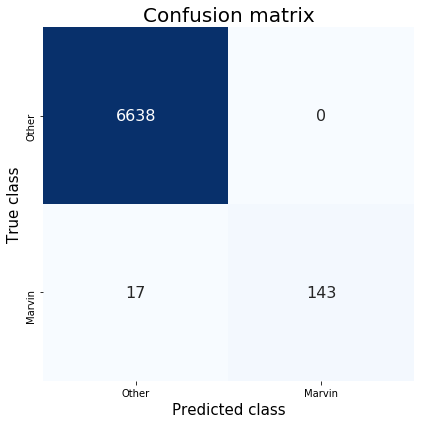

In [49]:
showResults(val_pred, val_true)

## GridSearch

In [173]:
from sklearn.metrics import f1_score

contamination_list = np.arange(0.01, 0.15, 0.005)
max_samples_list = np.arange(20, 220, 5)

best_score = 0
scores = np.zeros((contamination_list.shape[0], max_samples_list.shape[0]))
best_parameters = {'contamination':0, 'max_samples':0}

iterations = contamination_list.shape[0] * max_samples_list.shape[0]
iteration = 1

for i, contamination in enumerate(contamination_list):
    for j, max_samples in enumerate(max_samples_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
        
        isf = IsolationForest(random_state=42, contamination=contamination, max_samples=max_samples, bootstrap='True', behaviour='new')
        isf.fit(X_train)
        
        val_pred = isf.predict(X_val)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score:
            print("New best score: {:4f}".format(score))     
            best_score = score
            best_parameters['contamination'] = contamination
            best_parameters['max_samples'] = max_samples
            
        scores[i][j] = score
        iteration += 1

New best score: 0.124501
New best score: 0.355204
New best score: 0.476923
New best score: 0.581006
Iteration 100/1120
Iteration 200/1120
Iteration 300/1120
Iteration 400/1120
Iteration 500/1120
Iteration 600/1120
Iteration 700/1120
Iteration 800/1120
Iteration 900/1120
Iteration 1000/1120
Iteration 1100/1120


In [185]:
best_parameters

{'contamination': 0.05499999999999999, 'max_samples': 175}

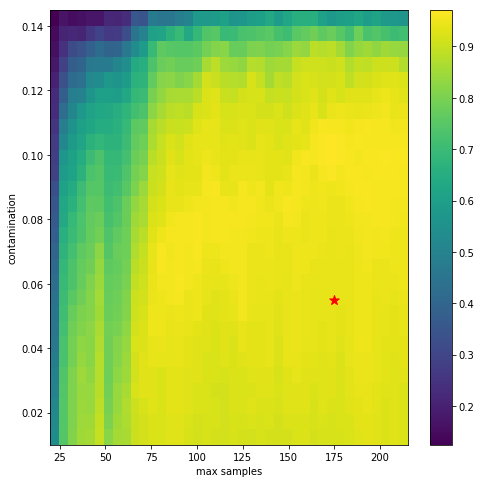

In [182]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores, aspect="auto", extent=[max_samples_list[0], max_samples_list[-1], contamination_list[0], contamination_list[-1]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('max samples')
ax.set_ylabel('contamination')

ax.scatter(best_parameters['max_samples'], best_parameters['contamination'], c='red', s=100, marker='*')

fig.show()

## More tests

In [0]:
import pandas as pd 

dfTest = pd.concat([testDF,finalTestDF],ignore_index=True)

In [0]:
testData = np.zeros((dfTest.shape[0], 99, 40))

for i,f in enumerate(dfTest['files']):
    testData[i] = _parse_fn(f)

In [192]:
dfTest['oc_class'] = dfTest.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
test_true = dfTest['oc_class'].tolist()
dfTest.head()

,files,labels,category,oc_class
0,speechData/train/bed/0c40e715_nohash_0.wav,16,bed,-1
1,speechData/train/bed/0ea0e2f4_nohash_0.wav,16,bed,-1
2,speechData/train/bed/0ea0e2f4_nohash_1.wav,16,bed,-1
3,speechData/train/bed/105a0eea_nohash_0.wav,16,bed,-1
4,speechData/train/bed/1528225c_nohash_0.wav,16,bed,-1


In [196]:
bestIsf = IsolationForest(random_state=42, contamination=0.055, max_samples=175, bootstrap='True', behaviour='new')
bestIsf.fit(X_train)

IsolationForest(behaviour='new', bootstrap='True', contamination=0.055,
                max_features=1.0, max_samples=175, n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [0]:
X_test = getFeatures(testData)
test_pred = bestIsf.predict(X_test)

Accuracy: 0.9977
Precision: 0.9667
Recal: 0.8951
F1-score: 0.9295


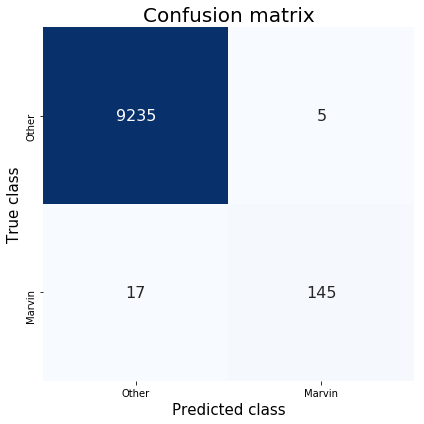

In [204]:
showResults(test_pred, test_true)

## SVM

In [227]:
gamma_list = np.arange(0.0001, 0.02, 0.0001)
nu_list = np.arange(0.000001, 0.0002, 0.000001)

best_score_svm = 0
scores_svm = np.zeros((gamma_list.shape[0], nu_list.shape[0]))
best_parameters_svm = {'gamma':0, 'nu':0}

iterations = gamma_list.shape[0] * nu_list.shape[0]
iteration = 1

for i, gamma in enumerate(gamma_list):
    for j, nu in enumerate(nu_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
            
        oc_svm = svm.OneClassSVM(gamma=gamma, nu=nu)
        ocmodel = oc_svm.fit(X_train)
   
        val_pred = oc_svm.predict(X_val)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score_svm:
            print("New best score: {:4f}".format(score))     
            best_score_svm = score
            best_parameters_svm['gamma'] = gamma
            best_parameters_svm['nu'] = nu
            
        scores_svm[i][j] = score
        iteration += 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


New best score: 0.892734
Iteration 100/39800
Iteration 200/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 300/39800
Iteration 400/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 500/39800
Iteration 600/39800
New best score: 0.915254
New best score: 0.950617
Iteration 700/39800
Iteration 800/39800
New best score: 0.955975
Iteration 900/39800
Iteration 1000/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 1100/39800
Iteration 1200/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 1300/39800
Iteration 1400/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 1500/39800
Iteration 1600/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 1700/39800
Iteration 1800/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 1900/39800
Iteration 2000/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 2100/39800
Iteration 2200/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 2300/39800
Iteration 2400/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 2500/39800
Iteration 2600/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 2700/39800
Iteration 2800/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 2900/39800
Iteration 3000/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 3100/39800
Iteration 3200/39800


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration 3300/39800


KeyboardInterrupt: ignored

In [228]:
print(best_score_svm)
print(best_parameters_svm)

0.9559748427672956
{'gamma': 0.0005, 'nu': 5.999999999999999e-06}


In [232]:
oc_svm = svm.OneClassSVM(gamma=5e-4, nu=6e-06)
oc_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0005, kernel='rbf',
            max_iter=-1, nu=6e-06, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [0]:
test_pred = oc_svm.predict(X_test)

Accuracy: 0.9990
Precision: 1.0000
Recal: 0.9444
F1-score: 0.9714


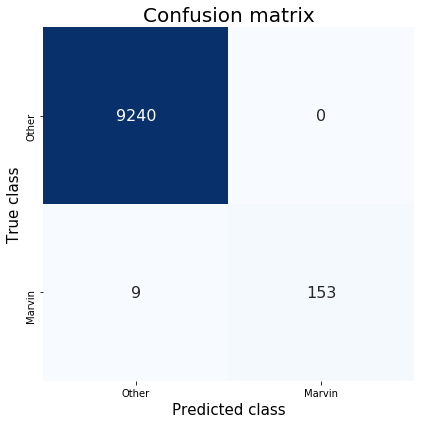

In [234]:
showResults(test_pred, test_true)

## Prediction Time

In [239]:
%%time
f = getFeatures(testData[0].reshape(1,99,40))
oc_svm.predict(f)

CPU times: user 347 ms, sys: 2 ms, total: 349 ms
Wall time: 348 ms


In [240]:
%%time
f = getFeatures(testData[0].reshape(1,99,40))
bestIsf.predict(f)

CPU times: user 405 ms, sys: 4.97 ms, total: 410 ms
Wall time: 412 ms
